# Project: Investigate a Dataset of No-Show Appointments!

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
* 'ScheduledDay' tells us on what day the patient set up their appointment.
* 'Neighborhood' indicates the location of the hospital. 
* 'Scholarship' indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
* Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

This report will investigate the following questions:
1. Does the weekday affect the rate of appointment no-shows?
2. Does booking an appointment earlier result in more or less no-shows?
2. Does sending an SMS result in less no-shows? 
3. Are low-income patients (enrolled in Brasilian welfare program) more likely to cancel? 

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import datetime

<a id='wrangling'></a>
## Data Wrangling
### General Properties

In [2]:
# Load data
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Check for number of rows, null values, and field types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There are 110527 entries - all entries are non-null. 

In [5]:
# Examine statistics for each numerical field
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The average age of patients is 37. 

% of patients that have:
* Scholarship (welfare): 9.8%
* Hypertension: 19.7%
* Diabetes: 7.2%
* Alcoholism: 3.0%
* Handicap: 2.2%
* Receied SMS: 32.1%

In [14]:
# Confirm the number of unique entries are in each column
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hypertension           2
Diabetes               2
Alcoholism             2
Handicap               5
SMS_received           2
No-show                2
dtype: int64

'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'No-show' appear to be True/False values, as they have two unique values (0/1, or yes/no). 

In [15]:
# Check for duplicate data
sum(df.duplicated())

0

There appears to be no duplicated data. 

### Data Cleaning
After initial investigation of the data, some fields must be cleaned:
1. Rename typos in column names
1. Convert Scheduled Date and Appointment Date from string to date time
2. Convert True/False fields to Boolean

There is no need to clean missing or duplicate data. 

In [16]:
# Rename typos in column names
df.rename(columns = {'Hipertension': 'Hypertension', 'Handcap': 'Handicap'}, inplace=True)

In [17]:
#Convert Scheduled Date and Appointment Date from string to date time
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [18]:
def to_boolean(ltr):
    if ltr == 'No' or ltr == 0:
        return False
    elif ltr == 'Yes' or ltr == 1:
        return True

In [21]:
# Convert all true/false columns to Boolean
bool_cols = ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'No-show']

for c in bool_cols:
    df[c] = df[c].apply(lambda x: to_boolean(x))

In [22]:
# Confirm changes
df.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                 bool
Hypertension                bool
Diabetes                    bool
Alcoholism                  bool
Handicap                   int64
SMS_received                bool
No-show                     bool
dtype: object

All data types are as expected. 
### Helper functions

In [83]:
# Function to plot bar chart
def plot_grouped(grouped_df, xlabels, title, xaxis_label, yaxis_label):
    # Plot count of appointments by day of week
    ind = np.arange(len(xlabels))

    f, ax = plt.subplots(figsize=(10,5)) 
    plot = plt.bar(ind, grouped_df);

    # set xticks
    plt.xticks(ind, xlabels)

    # title and labels
    plt.title(title)
    plt.xlabel(xaxis_label)
    plt.ylabel(yaxis_label);

In [105]:
# Function to plot pie chart
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} Appointments)".format(pct, absolute)

def plot_pie(grouped_df, legend_title, plot_title):
    labels = list(grouped_df.index)

    f, ax = plt.subplots(figsize=(10,10)) 
    wedges, texts, autotexts = ax.pie(grouped_df, textprops=dict(color="w"), autopct=lambda pct: func(pct, grouped_df));

    # legend
    ax.legend(wedges, labels,
              title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    # title and labels
    plt.title(plot_title);
    
    # https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Does the day of week of the appointment affect the rate of appointment no-shows?


In [76]:
# Create new column for the day of week
df['Appointment_day_of_week'] = df['AppointmentDay'].apply(lambda x: datetime.datetime.weekday(x));

In [77]:
count_by_day = df.groupby('Appointment_day_of_week').count()['No-show']
count_by_day[6] = 0

count_by_day

Appointment_day_of_week
0    22715
1    25640
2    25867
3    17247
4    19019
5       39
6        0
Name: No-show, dtype: int64

In [78]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

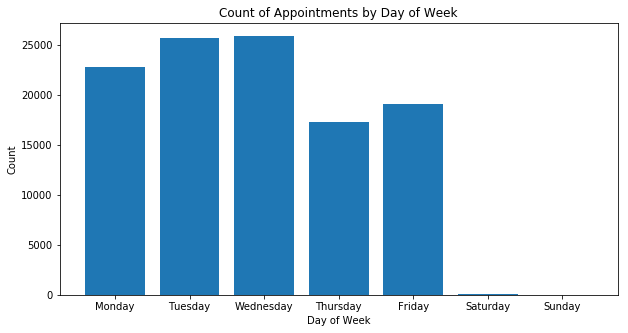

In [84]:
# Plot on bar graph the proportion of Appointment Counts for each day
plot_grouped(count_by_day, days_of_week, 'Count of Appointments by Day of Week', 'Day of Week', 'Count')

Majority of appointments are on weekdays (Monday - Friday), with no appointments on Sunday. The figure above demonstrates that Tuesday and Wednesday have the most appointments. There are fewer appointments on Thursday and Friday. 

In [85]:
# Calculate no-shows proportion
no_show_by_day = df.groupby('Appointment_day_of_week').sum()['No-show']

no_show_prop_by_day = no_show_by_day/count_by_day
no_show_prop_by_day = no_show_prop_by_day[0:6]
days_of_week = days_of_week[0:6]

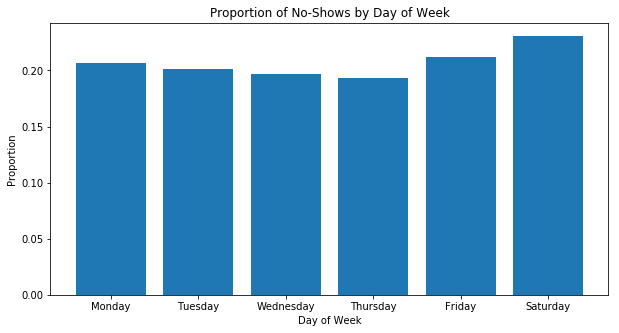

In [87]:
# Plot on bar graph the proportion of No-Shows for each day
plot_grouped(no_show_prop_by_day, days_of_week, 'Proportion of No-Shows by Day of Week', 'Day of Week', 'Proportion')

All days have similar rates of no-shows of around 20-25%, so it seems the day of the week that the appointment is on does not affect the rate of No-Shows of patients. 

### Research Question 2: Does booking an appointment earlier result in more or less no-shows?

In [88]:
# Create new column to calculate the number of days appointments were made in advance
df['days_scheduled_advanced'] = (df['ScheduledDay'] - df['AppointmentDay']).dt.days * -1

In [89]:
# Create bins to categorize into number of weeks in advance appointments were made
n = 11

bins = np.arange(-1, n) * 7
bins += 1
bins[-1] = df['days_scheduled_advanced'].max()

In [90]:
# Create labels to categorize into number of weeks in advance appointments were made
labels = [0]

for wks in np.arange(1, n-1):
    labels.append('<={}'.format(wks))

labels.append('>9')
labels

[0, '<=1', '<=2', '<=3', '<=4', '<=5', '<=6', '<=7', '<=8', '<=9', '>9']

In [91]:
# Create column for number of weeks scheduled in advance column
df['num_wks_scheduled'] = pd.cut(df['days_scheduled_advanced'], bins, labels=labels)

In [92]:
# Group by number of weeks category
count_by_adv_schedule = df.groupby('num_wks_scheduled').count()['No-show']

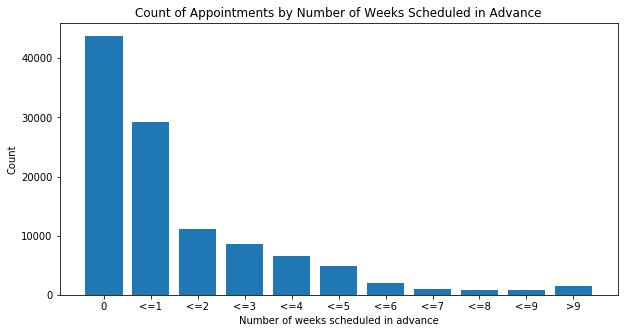

In [93]:
# Plot count of appointments by number of weeks appointment was made in advance
plot_grouped(count_by_adv_schedule, labels, 'Count of Appointments by Number of Weeks Scheduled in Advance', 'Number of weeks scheduled in advance', 'Count')

Most appointments were made on the same day, as well as within the first week. As the number of weeks increases, the number of appointments decreases in exponential decay.

In [95]:
# Calculate proportion
no_show_by_adv = df.groupby('num_wks_scheduled').sum()['No-show']

no_show_prop_by_adv = no_show_by_adv/count_by_adv_schedule

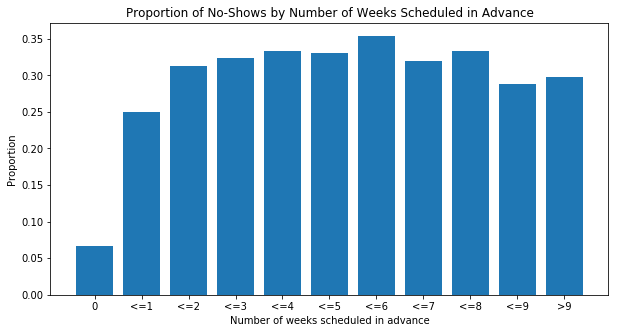

In [96]:
# Plot proportion of No-Shows by number of weeks appointment was made in advance
plot_grouped(no_show_prop_by_adv, labels, 'Proportion of No-Shows by Number of Weeks Scheduled in Advance', 'Number of weeks scheduled in advance', 'Proportion')

Same-day scheduled appointments had a relatively low rate of No-Shows, at around 6%. Appointments scheduled within a week has a rate of No-Show of approximately 25%. Appointments scheduled more in advanced have similar No-Show rates, at around 30-35%. The no-show rate dips slightly for appointments scheduled between 8-9 weeks in advance. 

### Research Question 3: Does sending an SMS result in less no-shows?

In [98]:
# Confirm values for SMS_received 
df['SMS_received'].unique()

array([False,  True])

In [99]:
# Group by SMS_received
count_by_SMS = df.groupby('SMS_received').count()['No-show']

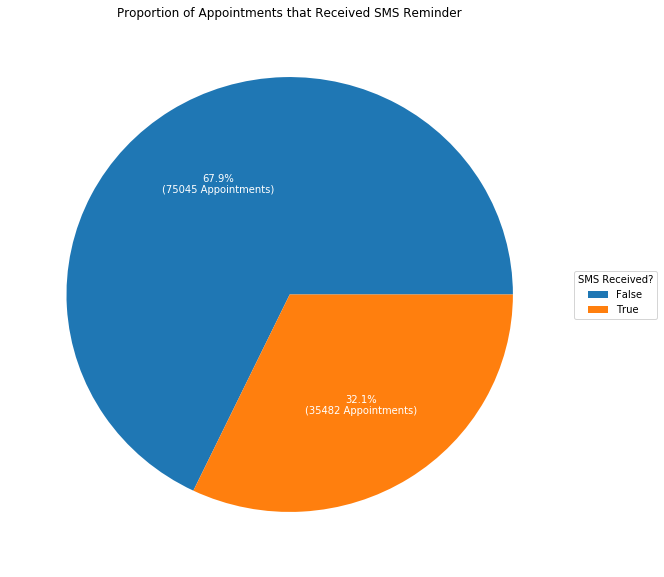

In [104]:
# Plot pie chart comparing number of appointments that received an SMS Reminder vs not
plot_pie(count_by_SMS, 'SMS Received?', 'Proportion of Appointments that Received SMS Reminder')

The majority (67.9%) of patients did not receive SMS reminders for their appointment. 

In [113]:
# Calculate proportion based on SMS Received
prop_noshow_by_SMS = df.groupby('SMS_received').sum()['No-show']/count_by_SMS
prop_noshow_by_SMS

SMS_received
False    0.167033
True     0.275745
Name: No-show, dtype: float64

In [116]:
labels = list(prop_noshow_by_SMS.index)
labels

[False, True]

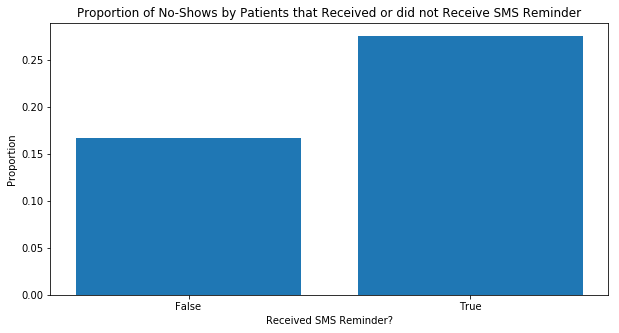

In [117]:
# Plot proportion of No-Shows by number of weeks appointment was made in advance
plot_grouped(prop_noshow_by_SMS, labels, 'Proportion of No-Shows by Patients that Received or did not Receive SMS Reminder', 'Received SMS Reminder?', 'Proportion')

Patients that received SMS reminders had a higher rate of No-Shows (apprx 28%) than patients that did not receive reminders (apprx. 16%). 

### Research Question 4: Are low-income patients (enrolled in Brasilian welfare program) more likely to cancel?

In [107]:
count_by_scholarship = df.groupby('Scholarship').count()['No-show']

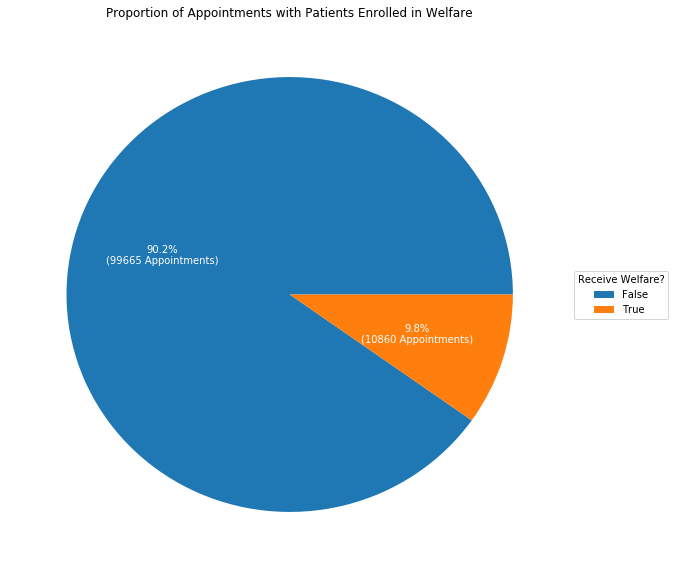

In [111]:
# Plot pie chart comparing number of appointments with patients that are enrolled in welfare or not
plot_pie(count_by_scholarship, 'Receive Welfare?', 'Proportion of Appointments with Patients Enrolled in Welfare')

The vast majority (90.2%) of patients that had appointments are not enrolled in welfare. 

In [119]:
# Calculate proportion of no-shows based on welfare enrollment
prop_noshow_by_scholarship = df.groupby('Scholarship').sum()['No-show']/count_by_scholarship
prop_noshow_by_scholarship

Scholarship
False    0.198072
True     0.237363
Name: No-show, dtype: float64

In [120]:
labels = list(prop_noshow_by_scholarship.index)
labels

[False, True]

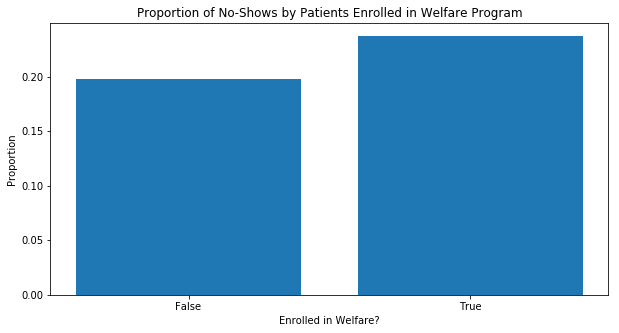

In [121]:
# Plot proportion of No-Shows by number of weeks appointment was made in advance
plot_grouped(prop_noshow_by_scholarship, labels, 'Proportion of No-Shows by Patients Enrolled in Welfare Program', 'Enrolled in Welfare?', 'Proportion')

Patients enrolled in welfare had a 25% rate of No-Shows, while patients not enrolled in welfare had a 20% rate of No-Shows. This may indicate that those enrolled in welfare (that presumably are lower-income), are more prone to No-Shows. 

<a id='conclusions'></a>
## Conclusions

This analysis resulted in the following findings:

* Almost all appointments were on weekdays. Earlier in the week (Monday - Wednesday) are more popular days for appointments. The day of week of the appointment doesn't seem to affect the rate of No-Shows much. Friday and Saturday have a slightly higher rate of No-Shows. 
* Most appointments were made on the same day, or within a week in advance. Appointments scheduled on the same day had a significantly lower rate of No-Show. Scheduling within a week in advance had a slightly lower rate of No-Shows.
* Most patients (67.9%) did not receive SMS Reminders. Patients that received an SMS reminder had a higher rate of no-show.
* 9.8% of appointments were for patients that are enrolled in the welfare program. Appointments made by patients that are enrolled in the welfare program had a higher rate of no-shows.

This analysis has limitations, in that for each variable studied, statistical analyses were not conducted. For example, when looking at the rate of No-Shows based on the day of the week, it was based on very few data points for Saturday, compared to other days. Considering the spread of the data may have resulted in different results. 

Another limitation is the lack of definition of the 'ScheduledDay' column, which was used in this analysis to determine how many days in advance the appointment was scheduled. If the appointment was scheduled in person, and an appointment was immediately available, the patient would not have been a No-Show, and therefore may have skewed the proportions to decrease the rate of No-Shows for same-day appointments. Including a time for the Appointment Date would have been helpful in understanding this distinction, or an additional column to indicate whether the appointment was scheduled remotely or not. 

This analysis also assumed that the 'SMS Received' column indicated that the SMS patients received included reminder information. However, the SMS content may have varied in how helpful the information contained was, such as the date, time, location, etc. 

The data may have also been biased, where patient information is likely self-reported. For example, in the analysis for those that are enrolled in welfare versus not, patients may have inaccurately reported their enrollment status. 